In [21]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

# --- Helper Classes (Inferred from your usage) ---
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0
        self.children = []

class Obstacle:
    def __init__(self, x, y, w, h):
        self.x, self.y = x, y
        self.w, self.h = w, h
    
    def contains(self, point):
        px, py = point
        # A simple Axis Aligned Bounding Box check
        return (self.x <= px <= self.x + self.w) and (self.y <= py <= self.y + self.h)

    def plot(self, ax):
        rect = plt.Rectangle((self.x, self.y), self.w, self.h, color='black')
        ax.add_patch(rect)

# --- BIT* Implementation ---

class BITStarMehor:
    def __init__(self, max_iters=500, batch_size=100, search_space = (-2, -2, 12, 12)):
        self.max_iters = int(max_iters)
        self.batch_size = batch_size
        self.goal_threshold = 0.5
        self.search_space = search_space
        
        # Plotting setup
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        
        self.nodes = []      # The tree (V_tree)
        self.samples = []    # Unconnected samples (V_unconnected)
        self.obstacles = []
        self.path = []
        
        # Search limits
        self.x_min, self.y_min = self.search_space[0], self.search_space[1]
        self.x_max, self.y_max = self.search_space[2], self.search_space[3]
        
        # BIT* Specifics
        self.c_best = float('inf') # Current best solution cost
        self.c_min = 0.0           # Distance from start to goal (Euclidean)
        self.start_node = None
        self.goal_node = None
        self.radius = 2.0          # Connection radius (simplified)

    def add_obstacle(self, obstacle):
        self.obstacles.append(obstacle)

    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def line_intersects_obstacle(self, x1, y1, x2, y2, obstacle):
        steps = 10 # Discretization for collision check
        for i in range(steps + 1):
            t = i / steps
            x = x1 + t * (x2 - x1)
            y = y1 + t * (y2 - y1)
            if obstacle.contains((x, y)):
                return True
        return False

    def collision_free(self, x1, y1, x2, y2):
        for obs in self.obstacles:
            if self.line_intersects_obstacle(x1, y1, x2, y2, obs):
                return False
        return True

    def build_path(self, node):
        path = []
        curr = node
        while curr is not None:
            path.append((curr.x, curr.y))
            curr = curr.parent
        return path[::-1]

    # --- INFORMED SAMPLING LOGIC ---
    
    def sample_batch(self, start_node, goal_node):
        """
        Samples a batch of points. 
        If c_best < inf, samples within the ellipse (Informed).
        Otherwise samples uniformly (Uninformed).
        """
        new_samples = []
        
        # Center of ellipse
        x_center = (start_node.x + goal_node.x) / 2.0
        y_center = (start_node.y + goal_node.y) / 2.0
        
        # Rotation of ellipse (align with start-goal axis)
        angle = math.atan2(goal_node.y - start_node.y, goal_node.x - start_node.x)
        
        # Coordinate bounds for uninformed sampling
        if self.c_best == float('inf'):
            for _ in range(self.batch_size):
                rn_x = random.uniform(self.x_min, self.x_max)
                rn_y = random.uniform(self.y_min, self.y_max)
                new_samples.append(Node(rn_x, rn_y))
        else:
            # Informed Sampling: Ellipse
            c_min = self.c_min
            c_max = self.c_best
            
            # Radii of ellipse
            # r1 is half the major axis length
            r1 = c_max / 2.0 
            # r2 is half the minor axis length (derived from focal distance)
            r2 = math.sqrt(c_max**2 - c_min**2) / 2.0
            
            # Rotation Matrix
            C = np.array([[math.cos(angle), -math.sin(angle)], 
                          [math.sin(angle),  math.cos(angle)]])
            
            # Diagonal Matrix (scaling)
            L = np.diag([r1, r2])
            
            for _ in range(self.batch_size):
                # Sample in unit ball
                x_ball = random.uniform(-1, 1)
                y_ball = random.uniform(-1, 1)
                # Rejection sampling for unit circle
                while x_ball**2 + y_ball**2 > 1:
                    x_ball = random.uniform(-1, 1)
                    y_ball = random.uniform(-1, 1)
                    
                # Transform: x = C * L * x_ball + center
                pt = np.dot(C, np.dot(L, np.array([x_ball, y_ball])))
                
                final_x = pt[0] + x_center
                final_y = pt[1] + y_center
                new_samples.append(Node(final_x, final_y))
                
        return new_samples

    def prune(self):
        """Remove nodes and samples that cannot possibly improve the solution"""
        if self.c_best == float('inf'):
            return

        # Prune samples (unconnected)
        self.samples = [n for n in self.samples if self.heuristic_cost(n) < self.c_best]

        # Prune tree nodes (connected)
        # Note: In a full strict BIT*, we would check g(n) + h(n) < c_best
        # Here we just keep the tree clean for visualization
        self.nodes = [n for n in self.nodes if (n.cost + self.dist_to_goal(n)) < self.c_best]

    def heuristic_cost(self, node):
        """Estimate total cost: Distance(Start->Node) + Distance(Node->Goal)"""
        # Note: For unconnected samples, we use Euclidean from start + Euclidean to goal
        # as a lower bound estimate.
        g_est = self.euclid_distance(self.start_node.x, node.x, self.start_node.y, node.y)
        h_est = self.euclid_distance(node.x, self.goal_node.x, node.y, self.goal_node.y)
        return g_est + h_est

    def dist_to_goal(self, node):
        return self.euclid_distance(node.x, self.goal_node.x, node.y, self.goal_node.y)

    def plot_tree(self, start, goal, final_path=False):
        self.ax.clear()
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot Obstacles
        for obs in self.obstacles:
            obs.plot(self.ax)

        # Plot Samples (The "Batch")
        if self.samples:
            sx = [n.x for n in self.samples]
            sy = [n.y for n in self.samples]
            self.ax.scatter(sx, sy, c='gray', s=5, alpha=0.4, label='Samples')

        # Plot Tree Edges
        for node in self.nodes:
            if node.parent:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)

        # Plot Start/Goal
        self.ax.plot(start.x, start.y, 'go', markersize=10, label='Start')
        self.ax.plot(goal.x, goal.y, 'ro', markersize=10, label='Goal')

        # Plot Ellipse (Visualizing the Informed set)
        if self.c_best != float('inf'):
            # Only for visualization of the bounding ellipse
            # Simple wireframe ellipse
            angle = math.atan2(goal.y - start.y, goal.x - start.x)
            center = ((start.x + goal.x)/2, (start.y + goal.y)/2)
            width = self.c_best
            height = math.sqrt(max(0, self.c_best**2 - self.c_min**2))
            
            ellipse = plt.matplotlib.patches.Ellipse(
                center, width, height, angle=math.degrees(angle), 
                fill=False, color='orange', linestyle='--', linewidth=2
            )
            self.ax.add_patch(ellipse)

        # Plot Final Path
        if self.path:
            px = [p[0] for p in self.path]
            py = [p[1] for p in self.path]
            self.ax.plot(px, py, 'g-', linewidth=3, label='Current Best')

        plt.title(f"BIT* | Cost: {self.c_best:.2f} | Nodes: {len(self.nodes)}")
        plt.draw()
        plt.pause(0.01)

    # --- MAIN RUN LOOP ---
    def run(self, start_pos, goal_pos, stop_on_first=True, visualize=False):
        """
        stop_on_first (bool): If True, stops as soon as a path is found. 
                              If False, runs until max_iters to optimize the path.
        """
        self.start_node = Node(start_pos[0], start_pos[1])
        self.goal_node = Node(goal_pos[0], goal_pos[1])
        
        self.nodes = [self.start_node]
        self.samples = [] 
        # c_min is the straight line distance (theoretical minimum)
        self.c_min = self.euclid_distance(start_pos[0], goal_pos[0], start_pos[1], goal_pos[1])
        self.c_best = float('inf')
        self.path = []
        
        # Main Loop
        for i in range(self.max_iters):
            
            # 1. Prune (Only happens if we are NOT stopping on first, 
            #    or if we found a path but continue running)
            self.prune()
            
            # 2. Sample New Batch
            new_batch = self.sample_batch(self.start_node, self.goal_node)
            self.samples.extend(new_batch)
            # print("Using fresh batch")
            
            # 3. Expansion Step
            self.samples.sort(key=lambda n: self.heuristic_cost(n))
            
            # Use a copy of the list so we can append to the real list while iterating
            current_tree = list(self.nodes) 
            n = 0
            
            for tree_node in current_tree:
                # print("checking new node")
                n +=1
                # Find neighbors
                neighbors = []
                for sample in self.samples:
                    dist = self.euclid_distance(tree_node.x, sample.x, tree_node.y, sample.y)
                    if dist <= self.radius:
                        neighbors.append((dist, sample))
                
                for dist, sample in neighbors:
                    new_cost = tree_node.cost + dist
                    n += 1
                    
                    # Optimization check
                    if new_cost + self.dist_to_goal(sample) < self.c_best:
                        if self.collision_free(tree_node.x, tree_node.y, sample.x, sample.y):
                            # Move from samples to tree
                            if sample in self.samples:
                                self.samples.remove(sample)
                                sample.parent = tree_node
                                sample.cost = new_cost
                                self.nodes.append(sample)

                                if n % 10 == 0 and visualize:
                                    self.plot_tree(self.start_node, self.goal_node, final_path=False)
                                    # pass

                                # Check Goal
                                dist_to_goal = self.dist_to_goal(sample)
                                if dist_to_goal < self.goal_threshold:
                                    total_cost = new_cost + dist_to_goal
                                    
                                    # Found a path!
                                    if total_cost < self.c_best:
                                        self.c_best = total_cost
                                        self.goal_node.parent = sample
                                        self.path = self.build_path(self.goal_node)
                                        # print(f"Path Found! Cost: {self.c_best:.2f}")
                                        
                                        # --- STOPPING LOGIC ---
                                        if stop_on_first:
                                            # print("Initial convergence reached. Stopping.")
                                            # Final plot to show the success
                                            if visualize:
                                                self.plot_tree(self.start_node, self.goal_node, final_path=True)
                                            return True, self.path

            # Visualization update during search
            if i % 2 == 0 and visualize:
                self.plot_tree(self.start_node, self.goal_node)
                # pass

        # self.plot_tree(self.start_node, self.goal_node, final_path=True)

        return (self.c_best != float('inf')), self.path

    def run_with_map_config(self, map_config, visualize=False):
        """
        Wrapper: Sets up the environment and calls the core run method.
        """
        # 1. Reinitialize Class Variables based on Map Config
        self.search_space = map_config['bounds']
        self.obstacles = map_config['obstacles']
        self.nodes = [] # Clear previous tree
        
        # 2. Extract Start and Goal
        start = map_config['start']
        goal = map_config['goal']
        
        # 3. Call the core logic
        return self.run(start, goal, visualize=visualize)

Final Path Length: 11


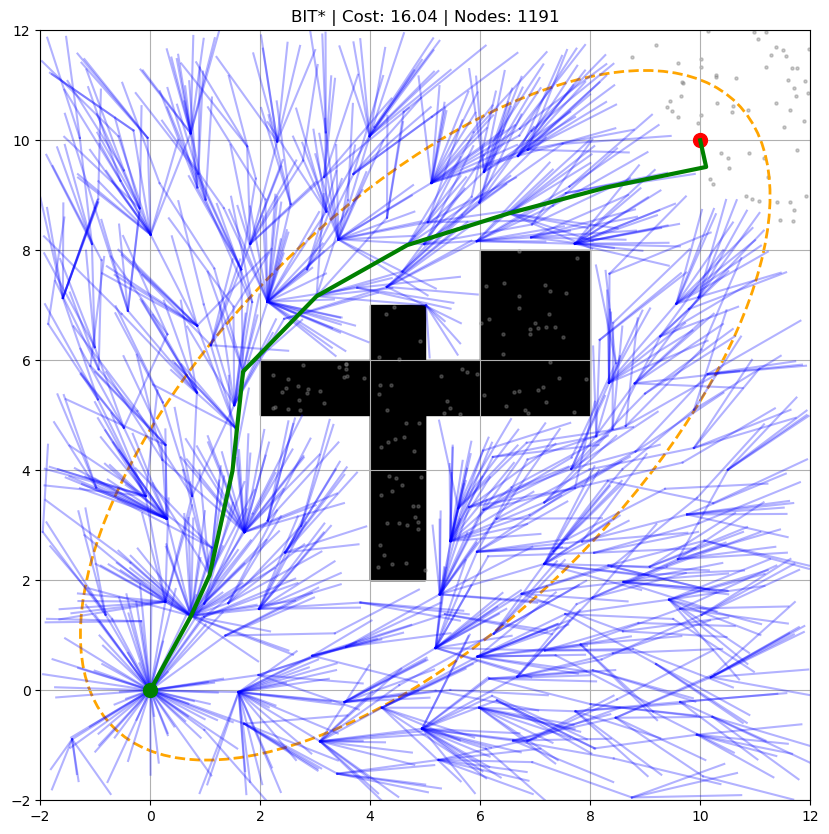

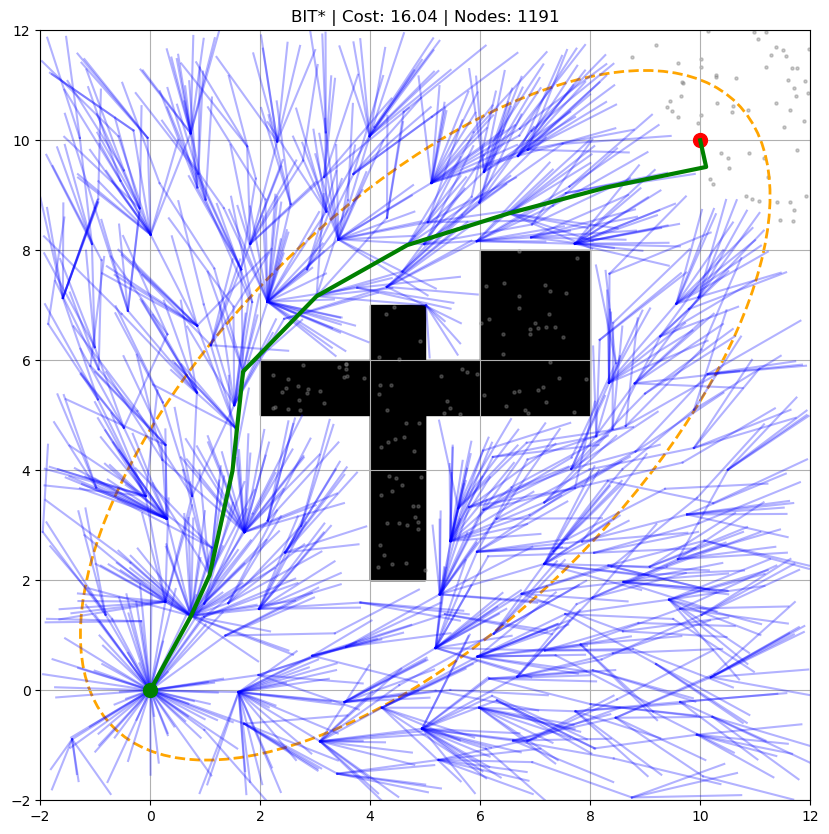

In [22]:
# --- EXECUTION ---

bit = BITStarMehor(max_iters=50, batch_size=150)

# Add obstacles
bit.add_obstacle(Obstacle(4, 2, 1, 5))
bit.add_obstacle(Obstacle(4, 2, 1, 3))
bit.add_obstacle(Obstacle(2, 5, 6, 1))
bit.add_obstacle(Obstacle(6, 6, 2, 2)) # Added one more for complexity

success, path = bit.run([0, 0], [10, 10], stop_on_first=True)#, visualize=True)

if success:
    print(f"Final Path Length: {len(path)}")
    bit.plot_tree(bit.start_node, bit.goal_node, final_path=True)
    plt.show() # Keep window open
else:
    print("Failed to find path.")

In [23]:
I am a huge fan of Dr. Gammells work. My undergraduate thesis is actually based around a lot of his earlier work on sampling on an informed subset to optimize RRT*. I actually also have a few ideas on possibly improving more of his recent work (BIT*, ABIT*). Apart from that I am extremely passionate about robotics, I have been involved in it since I was 18 (2019) and have had the privilege of working with real life industry standard hardware to develop software meant to work in real life context

SyntaxError: invalid syntax (1851127185.py, line 1)